# Klasifikasi Jenis Beras

# **Mengambil Dataset dari Google Grive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!unzip '/content/drive/My Drive/Klasifikasi Beras Tumpukan.zip'

Archive:  /content/drive/My Drive/Klasifikasi Beras Tumpukan.zip
   creating: .ipynb_checkpoints/
  inflating: .ipynb_checkpoints/demo_VGG-checkpoint.ipynb  
  inflating: .ipynb_checkpoints/VGG_demo-checkpoint.ipynb  
   creating: data/
   creating: data/image/
   creating: data/image/test/
   creating: data/image/test/Cilamaya/
  inflating: data/image/test/Cilamaya/C26.jpg  
  inflating: data/image/test/Cilamaya/C27.jpg  
  inflating: data/image/test/Cilamaya/C28.jpg  
  inflating: data/image/test/Cilamaya/C29.jpg  
  inflating: data/image/test/Cilamaya/C30.jpg  
   creating: data/image/test/IR64/
  inflating: data/image/test/IR64/I26.jpg  
  inflating: data/image/test/IR64/I27.jpg  
  inflating: data/image/test/IR64/I28.jpg  
  inflating: data/image/test/IR64/I29.jpg  
  inflating: data/image/test/IR64/I30.jpg  
   creating: data/image/test/Ketan/
  inflating: data/image/test/Ketan/K26.jpg  
  inflating: data/image/test/Ketan/K27.jpg  
  inflating: data/image/test/Ketan/K28.jpg  
  i

# **Mengambil Dataset dari Github**

In [0]:
!apt-get install subversion > /dev/null

!svn export https://github.com/Vidi005/Klasifikasi-Beras-Tumpukan/trunk/data > /dev/null
!svn export https://github.com/Vidi005/Klasifikasi-Beras-Tumpukan/trunk/utils > /dev/null
#!svn export https://github.com/Vidi005/Klasifikasi-Beras-Tumpukan/trunk/Klasifikasi Beras Tumpukan.ipynb > /dev/null

## Persiapan

How will you classify the bellow two images?

![1rice](https://github.com/totti0223/deep_learning_for_biologists_with_keras/raw/master/assets/11.jpg) Jenis Beras IR 64

![2rice](https://github.com/totti0223/deep_learning_for_biologists_with_keras/raw/master/assets/141.jpg) Jenis Beras Cilamaya

![2rice](https://github.com/totti0223/deep_learning_for_biologists_with_keras/raw/master/assets/140.jpg) Jenis Beras Ketan

In this tutorial, we will construct a classifier in 3 ways, giving you a rough implementation of how deep learning (step 3) can ignore the manual feature extraction we had to do (step 1 and 2). Although you may notice that the classification task is two easy that step 1 or step 2 is sufficient, will compare all steps for understanding.

Step 1. Manual Classsification by Conventional Approach

Step 2. Support Vector Machine based Classification

Step 3. Convolutional Neural Network based Classification

click the run button in each cell from the top to bottom and everything should run fine.
if you don't want to see the results beforehand, click "edit" and select "delete all the output of the cells"


## Memasukan Fungsi Library

In [3]:
import numpy as np 
import math, os, sys
import itertools

import matplotlib.pyplot as plt
plt.style.use('default')
from scipy import ndimage

from skimage import measure, morphology
from skimage.io import imsave, imread
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.transform import resize

from keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
import pandas as pd

Using TensorFlow backend.


In [0]:
#functions to assist visualizations

#confusion matrix drawing function provided by sklearn
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    #code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    #code from https://scikit-learn.org/stable/auto_examples/svm/plot_iris.html#sphx-glr-auto-examples-svm-plot-iris-py
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = plt.contourf(xx, yy, Z, **params)
    return out

## Mengimpor Dataset

In [5]:
#this command below see inspects part of the files which have been downloaded from the cell above
!ls data/image
!ls data/image/train
!ls data/image/train/Cilamaya
!ls data/image/train/IR64
!ls data/image/train/Ketan

test  test.txt	train  train.txt
Cilamaya  IR64	Ketan
C10.jpg  C13.jpg  C16.jpg  C19.jpg  C21.jpg  C24.jpg  C3.jpg  C6.jpg  C9.jpg
C11.jpg  C14.jpg  C17.jpg  C1.jpg   C22.jpg  C25.jpg  C4.jpg  C7.jpg
C12.jpg  C15.jpg  C18.jpg  C20.jpg  C23.jpg  C2.jpg   C5.jpg  C8.jpg
I10.jpg  I13.jpg  I16.jpg  I19.jpg  I21.jpg  I24.jpg  I3.jpg  I6.jpg  I9.jpg
I11.jpg  I14.jpg  I17.jpg  I1.jpg   I22.jpg  I25.jpg  I4.jpg  I7.jpg
I12.jpg  I15.jpg  I18.jpg  I20.jpg  I23.jpg  I2.jpg   I5.jpg  I8.jpg
K10.jpg  K13.jpg  K16.jpg  K19.jpg  K21.jpg  K24.jpg  K3.jpg  K6.jpg  K9.jpg
K11.jpg  K14.jpg  K17.jpg  K1.jpg   K22.jpg  K25.jpg  K4.jpg  K7.jpg
K12.jpg  K15.jpg  K18.jpg  K20.jpg  K23.jpg  K2.jpg   K5.jpg  K8.jpg


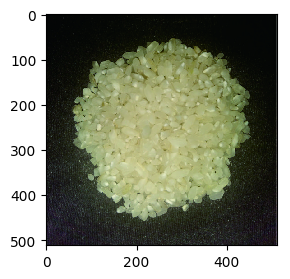

In [6]:
#let's visualize a single file
image = imread("data/image/train/Cilamaya/C17.jpg")
plt.figure(figsize=(3,3))
plt.imshow(image)

In [7]:
#lets load everything into memory first

#load training dataset
X_train = []
y_train = []
labels = ['Cilamaya', 'IR64', 'Ketan']

for i,label in enumerate(labels):
    folder = os.path.join("data/image/train",label)
    files = sorted(os.listdir(folder))
    files = [x for x in files if x.endswith(".jpg")]
    for k,file in enumerate(files):
        image_path = os.path.join(folder, file)
        
        image = imread(image_path)/255.
        image = resize(image,(511,511))
        X_train.append(image)
        category = os.path.split(folder)[-1]
        y_train.append(i)

'''for root, dirs, files in os.walk("data/image/train"):
    files = [x for x in files if x.endswith(".jpg")]
    for file in files:
        image_path = os.path.join(root, file)
        
        image = imread(image_path)/255.
        image = resize(image,(511,511))
        X_train.append(image)        
        category = os.path.split(root)[-1]
        if category == "Cilamaya":
            y_train.append(0)
        elif category == "IR64":
            y_train.append(1)
        else:
            y_train.append(2)'''
X_train = np.array(X_train)
y_train = np.array(y_train)



#load test dataset
X_test = []
y_test = []
labels = ['Cilamaya', 'IR64', 'Ketan']

for i,label in enumerate(labels):
    folder = os.path.join("data/image/test",label)
    files = sorted(os.listdir(folder))
    files = [x for x in files if x.endswith(".jpg")]
    for k,file in enumerate(files):
        image_path = os.path.join(folder, file)
        
        image = imread(image_path)/255.
        image = resize(image,(511,511))
        X_test.append(image)
        category = os.path.split(folder)[-1]
        y_test.append(i)

'''for root, dirs, files in os.walk("data/image/test"):
    files = [x for x in files if x.endswith(".jpg")]
    for file in files:
        image_path = os.path.join(root, file)
        
        image = imread(image_path)/255.
        image = resize(image,(511,511))
        X_test.append(image)        
        category = os.path.split(root)[-1]
        if category == "Cilamaya":
            y_test.append(0)
        elif category == "IR64":
            y_train.append(1)
        else:
            y_test.append(2)'''
X_test = np.array(X_test)
y_test = np.array(y_test)

print("train dataset shape is:", X_train.shape,y_train.shape)
print("test dataset shape is:", X_test.shape,y_test.shape)

train dataset shape is: (75, 511, 511, 3) (75,)
test dataset shape is: (15, 511, 511, 3) (15,)


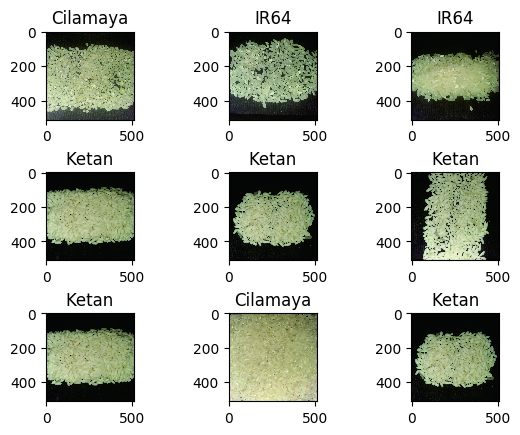

In [8]:
plt.subplots_adjust(wspace=0.4, hspace=0.6)

#randomly show several images from the training dataset
index = np.random.randint(0,X_train.shape[0],size=9)

for i, idx  in enumerate(index):
    plt.subplot(3,3,i+1)
    
    if y_train[idx] == 0:
        label = "Cilamaya"
    elif y_train[idx] == 1:
        label = "IR64"
    else:
        label = "Ketan"
    plt.title(label)
    plt.imshow(X_train[idx])

# Seperating the two classes with Deep learning (Convolutional Neural Network)

Finaly, we will use Convolutional Neural Network, a type of deep learning architecture that can handle images. By using CNN, we are freed from defining a suitable feature and only have to feed the images to the network. The CNN will find the most suitable features for classification

In [0]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras import layers
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split

## Prepare Input Data

In [0]:
y_train2 = to_categorical(y_train)
X_train3, X_valid3, y_train3, y_valid3 = train_test_split(X_train, y_train2, test_size=0.2, random_state=42)

## Model Construction

In [11]:
model = Sequential([
    layers.Conv2D(16, (3,3), input_shape=(511,511,3),name="conv1"),
    layers.Activation("relu"),
    layers.MaxPool2D((2,2),name="pool1"),
    layers.Dropout(0.25),
    layers.Conv2D(32, (3,3),name="conv2"),
    layers.Activation("relu"),
    layers.MaxPool2D((2,2),name="pool2"),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(64,name="fc1"),
    layers.Activation("relu"),
    layers.Dense(2,name="fc2"),
    layers.Activation("softmax")
])

model.compile("adam",loss="categorical_crossentropy",metrics=["acc"])
model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 509, 509, 16)      448       
_________________________________________________________________
activation_1 (Activation)    (None, 509, 509, 16)      0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 254, 254, 16)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 254, 254, 16)      0         
_________________________________________________________________
conv2 (Conv2D)               (None, 252, 252, 32)      4640      
_________________________________________________________________
activation_2 (Activation)    (None, 252, 252, 32)      0        

## Training

In [12]:
history = model.fit(x = X_train3, y = y_train3, batch_size=511, epochs= 100,validation_data=(X_valid3,y_valid3))

ValueError: ignored

## Visualizing Training Result

In [13]:
plt.plot(history.history["acc"],label="train_accuracy")
plt.plot(history.history["val_acc"],label="validation_accuracy")
plt.legend()
plt.show()

plt.plot(history.history["loss"],label="train_loss")
plt.plot(history.history["val_loss"],label="validation_loss")
plt.legend()
plt.show()

NameError: ignored

## Use the model

In [14]:
print(X_train3.shape)

(60, 511, 511, 3)


In [15]:
n = 39
input_image = X_train3[n][np.newaxis,...]
print("label is: ", y_train3[n])

predictions = model.predict(input_image)
print("prediction is",predictions[0])

label is:  [1. 0. 0.]






prediction is [0.4664407 0.5335593]


See that we just input image and get the results, while step 1 and step 2 required to construct feature(s) by our self.
This seed classification task was quite easy, but the complex the image gets, the harder to construct the most suitable feature gets.
That is when CNN shows its power.
See also the Yeast GFP protein localization tutorial for more complex image classification task.

# Membuat File *.h5 untuk Tensorflow Lite

In [0]:
import os
os.makedirs('./model', exist_ok=True)
model.save('./model/Klasifikasi Beras Tumpukan.h5')

In [0]:
from keras import backend as K
# This line must be executed before loading Keras model.
K.set_learning_phase(0)

In [19]:
from keras.models import load_model
model = load_model('./model/Klasifikasi Beras Tumpukan.h5')
print(model.outputs)
# [<tf.Tensor 'dense_2/Softmax:0' shape=(?, 10) dtype=float32>]
print(model.inputs)
# [<tf.Tensor 'conv2d_1_input:0' shape=(?, 28, 28, 1) dtype=float32>]

[<tf.Tensor 'activation_4_1/Softmax:0' shape=(?, 2) dtype=float32>]
[<tf.Tensor 'conv1_input_1:0' shape=(?, 511, 511, 3) dtype=float32>]


In [20]:
from keras import backend as K
import tensorflow as tf

def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        # Graph -> GraphDef ProtoBuf
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = convert_variables_to_constants(session, input_graph_def,
                                                      output_names, freeze_var_names)
        return frozen_graph


frozen_graph = freeze_session(K.get_session(),
                              output_names=[out.op.name for out in model.outputs])

Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 26 variables.
INFO:tensorflow:Converted 26 variables to const ops.


In [21]:
# Save to ./model/tf_model.pb
tf.train.write_graph(frozen_graph, "model", "tf_Klasifikasi_Beras_Tumpukan.pb", as_text=False)

'model/tf_Klasifikasi_Beras_Tumpukan.pb'

In [16]:
X_train3[1]

array([[[0.99957363, 0.99956214, 0.9995813 ],
        [0.64679353, 0.65461752, 0.68586738],
        [0.74039759, 0.74039375, 0.74022508],
        ...,
        [0.74392052, 0.74786511, 0.75955695],
        [0.63113422, 0.65459843, 0.64680898],
        [0.99955441, 0.9995966 , 0.99957358]],

       [[0.91708266, 0.89756299, 0.88584426],
        [0.09374969, 0.10550285, 0.10547982],
        [0.00395627, 0.01958888, 0.02347592],
        ...,
        [0.01179168, 0.01964249, 0.01571325],
        [0.04686337, 0.06249215, 0.05077346],
        [0.91313039, 0.93266536, 0.91704045]],

       [[0.99898315, 0.99889118, 0.99893718],
        [0.05860126, 0.06254212, 0.05080817],
        [0.01574355, 0.01972258, 0.01191772],
        ...,
        [0.00803434, 0.01203265, 0.01195591],
        [0.01564446, 0.01960446, 0.0156751 ],
        [0.99880685, 0.99493133, 0.99876854]],

       ...,

       [[0.97976657, 0.97976273, 0.97979727],
        [0.32114282, 0.27813608, 0.31331503],
        [0.21557182, 0